# **Correlation between the parametric and non-parametric results**

This notebook reproduces the figures present in Fig S2.

In [1]:
import harreman
import os
import json
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from scipy.stats import pearsonr, wilcoxon, mannwhitneyu, ranksums, zscore
import random
from sklearn import linear_model
from scipy.stats import hypergeom
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from plotnine import *
from matplotlib.patches import Patch
from scipy.cluster.hierarchy import fcluster
import math
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

## Functions

In [14]:
def corr_plot(x, y, mean_expr, max_num=10000, outlier=0.01, line_on=True, method='spearman',
              legend_on=True, size=30, dot_color=None, outlier_color="r",
              alpha=0.8, color_rate=10, corr_on=None, colorbar=True, pmax=95, pmin=5):

    if method == 'pearson':
        score = stats.pearsonr(x, y)
    if method == 'spearman':
        score = stats.spearmanr(x, y)
    np.random.seed(0)
    if len(x) > max_num:
        idx = np.random.permutation(len(x))[:max_num]
        x, y = x[idx], y[idx]
        mean_expr = mean_expr[idx]
    outlier = int(len(x) * outlier)

    xy = np.vstack([x, y])
    z = stats.gaussian_kde(xy)(xy)
    idx = z.argsort()
    idx1, idx2 = idx[outlier:], idx[:outlier]

    if dot_color is None:
        # c_score = np.log2(z[idx] + color_rate * np.min(z[idx]))
        c_score = mean_expr
    else:
        c_score = dot_color

    plt.set_cmap("Blues")
    vmax = np.percentile(c_score, pmax)
    vmin = np.percentile(c_score, pmin)
    plt.scatter(x, y, c=c_score, edgecolor=None, s=size, alpha=alpha, vmin=vmin, vmax=vmax)
    if colorbar:
        plt.colorbar()
    # plt.scatter(x[idx2], y[idx2], c=outlier_color, edgecolor=None, s=size / 5,
    #             alpha=alpha / 3.0)

    if line_on:
        clf = linear_model.LinearRegression()
        clf.fit(x.reshape(-1, 1), y)
        xx = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)
        yy = clf.predict(xx)
        plt.plot(xx, yy, "k--", label="R=%.3f" % score[0])

    if legend_on or corr_on:
        plt.legend(loc="best", fancybox=True, ncol=1)

## Slide-seq lung dataset

In [3]:
BASE_PATH = "/home/projects/nyosef/oier/Harreman_files/Slide_seq_lung"
ADATA_PATH = os.path.join(BASE_PATH, 'h5ads')
DATA_PATH = os.path.join(BASE_PATH, 'data')
PLOTS_PATH = os.path.join(BASE_PATH, 'plots')

### Metabolic Hotspot

In [38]:
adata = sc.read_h5ad(os.path.join(ADATA_PATH, 'Slide_seq_lung_adata.h5ad'))

In [39]:
sample_col = 'sample'
n_genes_expr = 50
genes_to_keep = np.zeros(adata.shape[1], dtype=bool)

for sample in adata.obs[sample_col].unique():
    adata_sample = adata[adata.obs[sample_col] == sample]
    expressed = np.array((adata_sample.X > 0).sum(axis=0)).flatten()
    genes_to_keep |= expressed >= n_genes_expr

adata = adata[:, genes_to_keep].copy()

In [40]:
harreman.tl.compute_knn_graph(adata, 
                           compute_neighbors_on_key="spatial", 
                           neighborhood_radius=100,
                           weighted_graph=False,
                           sample_key='sample',
                           verbose=True)

Computing the neighborhood graph...
Restricting graph within samples using 'sample'...


100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Computing the weights...
Finished computing the KNN graph in 6.947 seconds


In [41]:
harreman.hs.compute_local_autocorrelation(adata, layer_key="counts", model='bernoulli', species='human', use_metabolic_genes=True, permutation_test=True, verbose=True)

Computing local autocorrelation...


Permutation test: 100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]


Local autocorrelation results are stored in adata.uns['gene_autocorrelation_results']
Finished computing local autocorrelation in 410.278 seconds


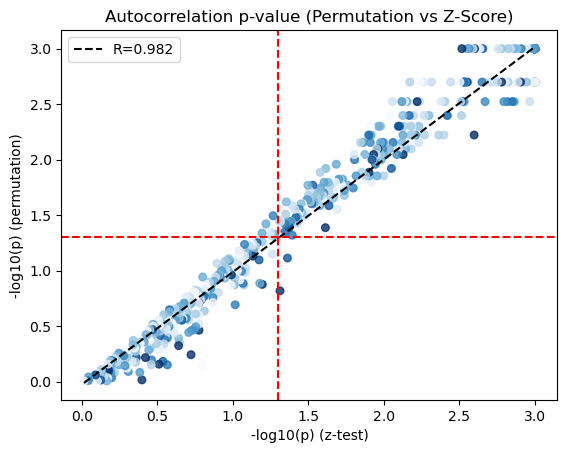

In [16]:
x = -np.log10(adata.uns['gene_autocorrelation_results'].Z_Pval.values)
y = -np.log10(adata.uns['gene_autocorrelation_results'].Perm_Pval.values)

genes = adata.uns['gene_autocorrelation_results'].index
# mean_expr = adata[:,genes].layers['log_norm'].mean(axis=0).A1

X = adata[:,genes].layers['log_norm'].tocsc()  # make sure it's column-compressed for efficient slicing
sums = X.sum(axis=0).A1
counts = (X > 0).sum(axis=0).A1
mean_expr = sums / counts
 
x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, mean_expr, method='spearman', colorbar=False, pmin=10, pmax=90)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Autocorrelation p-value (Permutation vs Z-Score)')
plt.savefig(os.path.join(PLOTS_PATH, 'p_np_autocorrelation_plot.pdf'))

We only use those genes with a significant autocorrelation (FDR < 0.01) for the subsequent analysis.

In [42]:
gene_autocorrelation_results = adata.uns['gene_autocorrelation_results']
genes = gene_autocorrelation_results.loc[gene_autocorrelation_results.Z_FDR < 0.01].sort_values('Z', ascending=False).index

In [43]:
harreman.hs.compute_local_correlation(adata, genes=genes, permutation_test=True, verbose=True)

Computing pair-wise local correlation on 605 features...


Permutation test: 100%|██████████| 1000/1000 [20:11<00:00,  1.21s/it]


Pair-wise local correlation results are stored in adata.uns with the following keys: ['lc_perm_pvals', 'lc_perm_pvals_sym', 'lcs', 'lc_zs', 'lc_z_pvals', 'lc_z_FDR']
Finished computing pair-wise local correlation in 1216.117 seconds


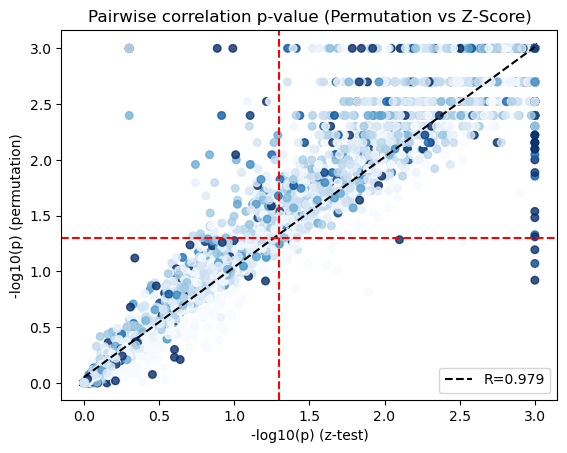

In [46]:
x = -np.log10(adata.uns['lc_z_pvals'].values).flatten()
y = -np.log10(adata.uns['lc_perm_pvals'].values).flatten()

genes = adata.uns['lc_z_pvals'].index
mean_expr = adata[:,genes].layers['log_norm'].mean(axis=0).A1
mean_expr_matrix = (mean_expr[:, np.newaxis] + mean_expr[np.newaxis, :]) / 2
mean_expr_values = mean_expr_matrix.flatten()
 
x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, mean_expr_values, method='spearman', colorbar=False, pmin=10, pmax=90)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Pairwise correlation p-value (Permutation vs Z-Score)')
plt.savefig(os.path.join(PLOTS_PATH, 'p_np_correlation_plot.pdf'))

### ct-agnostic Harreman

The *Harreman_perm_analysis.py* script was used to run the code.

In [28]:
adata = harreman.read_h5ad(os.path.join(ADATA_PATH, 'Slide_seq_lung_Harreman_perm.h5ad'))

In [29]:
genes = list(np.unique(adata.uns['genes']))
# mean_expr = pd.DataFrame(adata[:,genes].layers['log_norm'].mean(axis=0).A1,
#                          index=genes)

X = adata[:,genes].layers['log_norm'].tocsc()  # make sure it's column-compressed for efficient slicing
sums = X.sum(axis=0).A1
counts = (X > 0).sum(axis=0).A1
mean_expr = pd.DataFrame(sums / counts, index=genes)

In [30]:
def get_mean_expression(gene_or_list):
    if isinstance(gene_or_list, list):
        return mean_expr.loc[gene_or_list].mean().values[0]
    return mean_expr.loc[gene_or_list].values[0]

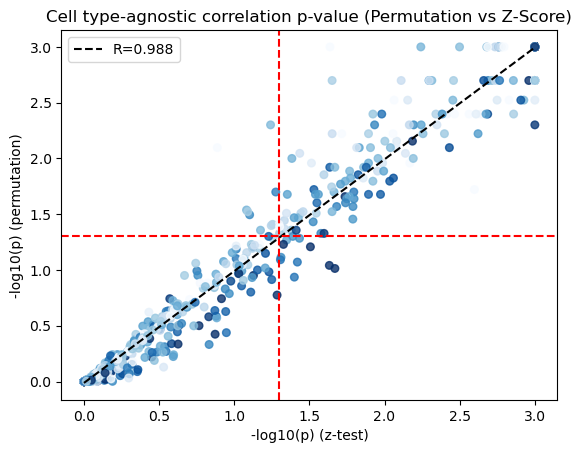

In [32]:
x = -np.log10(adata.uns['ccc_results']['cell_com_df_gp'].Z_pval.values)
y = -np.log10(adata.uns['ccc_results']['cell_com_df_gp'].pval_np)

mean_expressions = adata.uns['ccc_results']['cell_com_df_gp'][['Gene 1', 'Gene 2']].applymap(get_mean_expression).mean(axis=1)
mean_expr_values = mean_expressions.values

x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, mean_expr_values, method='spearman', colorbar=False, pmin=10, pmax=90)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Cell type-agnostic correlation p-value (Permutation vs Z-Score)')
plt.savefig(os.path.join(PLOTS_PATH, 'p_np_ct_agnostic_harreman_gp_plot.pdf'))

In [33]:
metabolite_means = {}
for met, indices in adata.uns["gene_pair_dict"].items():
    mean_value = mean_expressions.loc[indices].mean()  # Compute mean
    metabolite_means[met] = mean_value

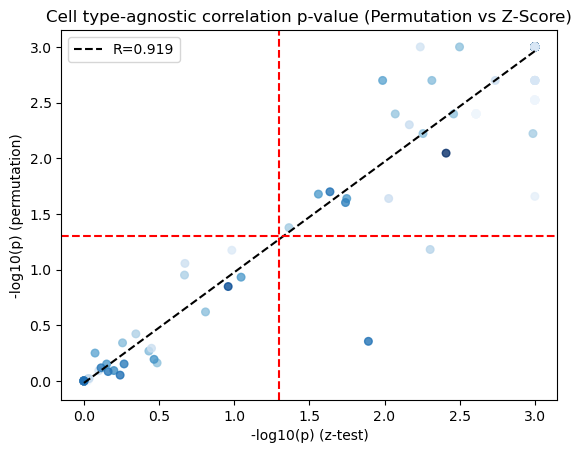

In [36]:
x = -np.log10(adata.uns['ccc_results']['cell_com_df_m'].Z_pval.values)
y = -np.log10(adata.uns['ccc_results']['cell_com_df_m'].pval_np)

metabolite_means = {}
for met, indices in adata.uns["gene_pair_dict"].items():
    mean_value = mean_expressions.loc[indices].mean()  # Compute mean
    metabolite_means[met] = mean_value
metab_score_values = list(metabolite_means.values())
 
x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, metab_score_values, method='spearman', colorbar=False, pmin=10, pmax=90)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Cell type-agnostic correlation p-value (Permutation vs Z-Score)')
plt.savefig(os.path.join(PLOTS_PATH, 'p_np_ct_agnostic_harreman_m_plot.pdf'))

## Visium colon dataset

In [2]:
BASE_PATH = "/home/projects/nyosef/oier/Harreman_files/Visium_colon"
ADATA_PATH = os.path.join(BASE_PATH, 'h5ads')
DATA_PATH = os.path.join(BASE_PATH, 'data')
PLOTS_PATH = os.path.join(BASE_PATH, 'plots')

### Metabolic Hotspot

In [3]:
adata = ad.read_h5ad(os.path.join(ADATA_PATH, 'Visium_colon_unrolled_adata.h5ad'))

In [4]:
sample_col = 'cond'
n_genes_expr = 50
genes_to_keep = np.zeros(adata.shape[1], dtype=bool)

for sample in adata.obs[sample_col].unique():
    adata_sample = adata[adata.obs[sample_col] == sample]
    expressed = np.array((adata_sample.X > 0).sum(axis=0)).flatten()
    genes_to_keep |= expressed >= n_genes_expr

adata = adata[:, genes_to_keep].copy()

In [5]:
harreman.tl.compute_knn_graph(adata, 
                           compute_neighbors_on_key="spatial_unrolled", 
                           n_neighbors=5,
                           weighted_graph=False,
                           sample_key='cond',
                           verbose=True)

Computing the neighborhood graph...
Restricting graph within samples using 'cond'...


100%|██████████| 2/2 [00:00<00:00, 119.72it/s]

Computing the weights...
Finished computing the KNN graph in 0.033 seconds


In [6]:
harreman.hs.compute_local_autocorrelation(adata, layer_key="counts", model='danb', species='mouse', use_metabolic_genes=True, permutation_test=True, verbose=True)

Computing local autocorrelation...


Permutation test: 100%|██████████| 1000/1000 [00:03<00:00, 325.03it/s]

Local autocorrelation results are stored in adata.uns['gene_autocorrelation_results']
Finished computing local autocorrelation in 4.090 seconds


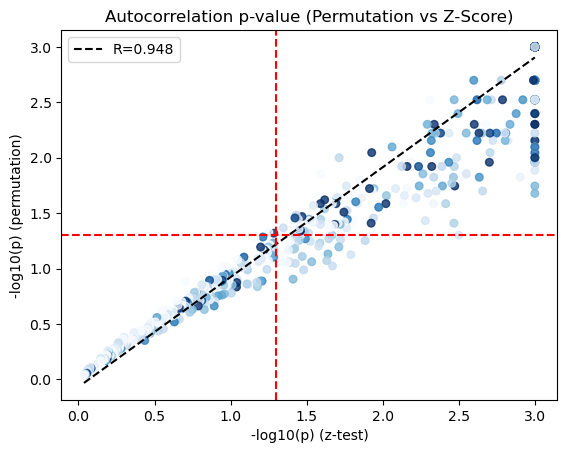

In [9]:
x = -np.log10(adata.uns['gene_autocorrelation_results'].Z_Pval.values)
y = -np.log10(adata.uns['gene_autocorrelation_results'].Perm_Pval.values)

genes = adata.uns['gene_autocorrelation_results'].index
# mean_expr = adata[:,genes].layers['log_norm'].mean(axis=0).A1

X = adata[:,genes].layers['log_norm'].tocsc()  # make sure it's column-compressed for efficient slicing
sums = X.sum(axis=0).A1
counts = (X > 0).sum(axis=0).A1
mean_expr = sums / counts
 
x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, mean_expr, method='spearman', colorbar=False, pmin=10, pmax=60)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Autocorrelation p-value (Permutation vs Z-Score)')
plt.savefig(os.path.join(PLOTS_PATH, 'p_np_autocorrelation_plot.pdf'))

In [7]:
gene_autocorrelation_results = adata.uns['gene_autocorrelation_results']
genes = gene_autocorrelation_results.loc[gene_autocorrelation_results.Z_FDR < 0.01].sort_values('Z', ascending=False).index

In [8]:
harreman.hs.compute_local_correlation(adata, genes=genes, permutation_test=True, verbose=True)

Computing pair-wise local correlation on 759 features...


Permutation test: 100%|██████████| 1000/1000 [00:38<00:00, 26.07it/s]


Pair-wise local correlation results are stored in adata.uns with the following keys: ['lc_perm_pvals', 'lc_perm_pvals_sym', 'lcs', 'lc_zs', 'lc_z_pvals', 'lc_z_FDR']
Finished computing pair-wise local correlation in 38.722 seconds


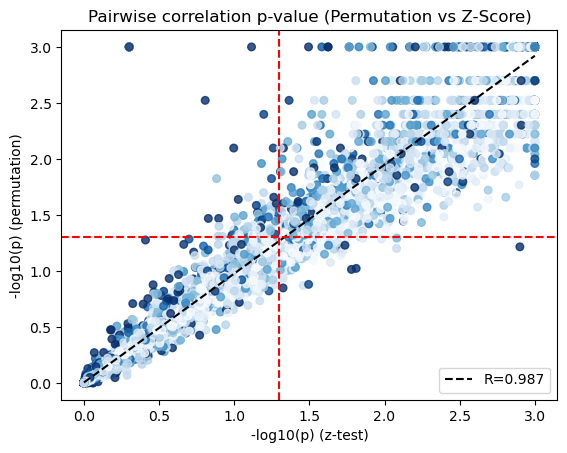

In [13]:
x = -np.log10(adata.uns['lc_z_pvals'].values).flatten()
y = -np.log10(adata.uns['lc_perm_pvals'].values).flatten()
# y = -np.log10(adata.uns['lc_perm_pvals_sym'].values).flatten()

genes = adata.uns['lc_z_pvals'].index
# mean_expr = adata[:,genes].layers['log_norm'].mean(axis=0).A1

X = adata[:,genes].layers['log_norm'].tocsc()  # make sure it's column-compressed for efficient slicing
sums = X.sum(axis=0).A1
counts = (X > 0).sum(axis=0).A1
mean_expr = sums / counts

mean_expr_matrix = (mean_expr[:, np.newaxis] + mean_expr[np.newaxis, :]) / 2
mean_expr_values = mean_expr_matrix.flatten()
 
x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, mean_expr_values, method='spearman', colorbar=False, pmin=10, pmax=90)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Pairwise correlation p-value (Permutation vs Z-Score)')
plt.savefig(os.path.join(PLOTS_PATH, 'p_np_correlation_plot.pdf'))

### ct-agnostic Harreman

In [9]:
def harreman_pipeline(adata, verbose):

    harreman.pp.extract_interaction_db(adata, species='mouse', database='both')
    
    harreman.tl.compute_knn_graph(adata, 
                           compute_neighbors_on_key="spatial_unrolled", 
                           n_neighbors=5,
                           weighted_graph=False,
                           sample_key='cond',
                           verbose=verbose,
                           )
    
    harreman.tl.apply_gene_filtering(adata, layer_key='counts', model='danb', autocorrelation_filt = True, verbose=verbose)

    harreman.tl.compute_gene_pairs(adata, ct_specific = False, verbose=verbose)

    harreman.tl.compute_cell_communication(adata, model='danb', M = 1000, test = "both", layer_key_p_test='counts', layer_key_np_test='counts', center_counts_for_np_test=True, verbose=verbose)

    harreman.tl.select_significant_interactions(adata, test = "non-parametric", threshold = 0.05)

    return adata

In [10]:
adata = harreman_pipeline(adata, verbose=True)

Computing the neighborhood graph...
Restricting graph within samples using 'cond'...


100%|██████████| 2/2 [00:00<00:00, 121.10it/s]

Computing the weights...
Finished computing the KNN graph in 0.027 seconds
Applying gene filtering...


Finished applying gene filtering in 0.189 seconds
Computing gene pairs...
Finished computing gene pairs in 1.842 seconds
Starting cell-cell communication analysis...
Running the parametric test...
Parametric test finished.
Running the non-parametric test...


Permutation test: 100%|██████████| 1000/1000 [00:38<00:00, 25.82it/s]


Non-parametric test finished.
Obtaining the communication results...
Finished computing cell-cell communication analysis in 39.955 seconds


In [11]:
genes = list(np.unique(adata.uns['genes']))
# mean_expr = pd.DataFrame(adata[:,genes].layers['log_norm'].mean(axis=0).A1,
#                          index=genes)

X = adata[:,genes].layers['log_norm'].tocsc()
sums = X.sum(axis=0).A1
counts = (X > 0).sum(axis=0).A1
mean_expr = pd.DataFrame(sums / counts, index=genes)

In [12]:
def get_mean_expression(gene_or_list):
    if isinstance(gene_or_list, list):
        return mean_expr.loc[gene_or_list].mean().values[0]
    return mean_expr.loc[gene_or_list].values[0]

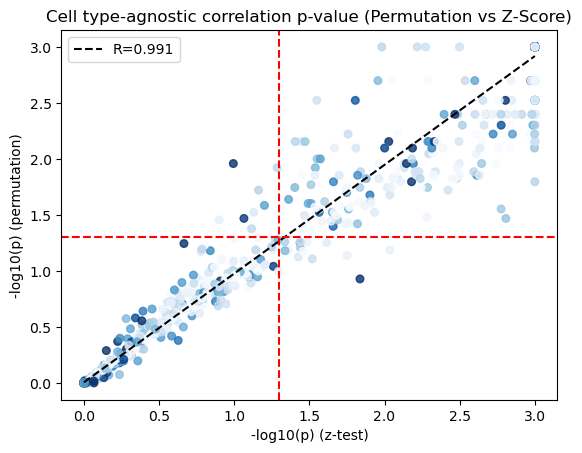

In [16]:
x = -np.log10(adata.uns['ccc_results']['cell_com_df_gp'].Z_pval.values)
y = -np.log10(adata.uns['ccc_results']['cell_com_df_gp'].pval_np)

mean_expressions = adata.uns['ccc_results']['cell_com_df_gp'][['Gene 1', 'Gene 2']].applymap(get_mean_expression).mean(axis=1)
mean_expr_values = mean_expressions.values

x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, mean_expr_values, method='spearman', colorbar=False, pmin=10, pmax=90)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Cell type-agnostic correlation p-value (Permutation vs Z-Score)')
plt.savefig(os.path.join(PLOTS_PATH, 'p_np_ct_agnostic_harreman_gp_plot.pdf'))

In [17]:
metabolite_means = {}
for met, indices in adata.uns["gene_pair_dict"].items():
    mean_value = mean_expressions.loc[indices].mean()  # Compute mean
    metabolite_means[met] = mean_value

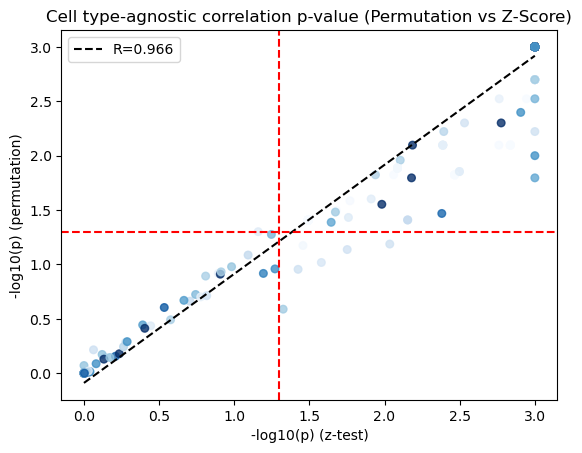

In [22]:
# global consistency
x = -np.log10(adata.uns['ccc_results']['cell_com_df_m'].Z_pval.values)
y = -np.log10(adata.uns['ccc_results']['cell_com_df_m'].pval_np)

metabolite_means = {}
for met, indices in adata.uns["gene_pair_dict"].items():
    mean_value = mean_expressions.loc[indices].mean()  # Compute mean
    metabolite_means[met] = mean_value
metab_score_values = list(metabolite_means.values())
 
x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, metab_score_values, method='spearman', colorbar=False, pmin=10, pmax=80)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Cell type-agnostic correlation p-value (Permutation vs Z-Score)')
plt.savefig(os.path.join(PLOTS_PATH, 'p_np_ct_agnostic_harreman_m_plot.pdf'))